In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
pi = math.pi
from prepare import prep_fish, fish_split, add_scaled_columns
from model import ols_model, plot_residuals, linear_regression, laso_lars, polynomial_features
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from statsmodels.formula.api import ols
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
plt.rc("figure", figsize=(12, 7))
plt.rc("font", size=14)

# Acquire and Prepare

In [2]:
df = pd.read_csv('Fish.csv')

In [3]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


### Have 7 columns and 159 rows of data. Species is categorical and all other columns are continuous measurement variables. Need to see what measurement values are and what each length means. 

## Column descriptions
    - Species: Species name of fish
    - Weight: Weight of fish in grams
    - Length1: Vertical length in cm
    - Length2: Diagonal length in cm
    - Length3: Cross length in cm
    - Height: Height in cm
    - Width: Diagonal width in cm

### Going to rename the lengths to interpret easier and make measurements in pounds and inches

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


### Do not need to worry about nulls

In [5]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


 ### Have a high std on weight. Averages across lengths are not too different.

In [6]:
df.Species.nunique()

7

### We have 7 different species

In [7]:
df.Species.value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

## Going to lower case all columns, rename length columns and lower case fish species for preparation

In [8]:
df.columns = df.columns.str.lower()
df.head()

,species,weight,length1,length2,length3,height,width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [9]:
df = df.rename(columns={'length1': 'vertical_length', 'length2': 'diagonal_length', 'length3': 'cross_length'})
df.head()

,species,weight,vertical_length,diagonal_length,cross_length,height,width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [10]:
# Lower casing species names
df.species=df.species.str.lower()

In [11]:
df.head()

,species,weight,vertical_length,diagonal_length,cross_length,height,width
0,bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,bream,430.0,26.5,29.0,34.0,12.4440,5.1340


## Going to make some custom measurements ```avg_lengths``` and estimated area```est_area```. Estimating area by assuming fish is an ellipse shape

In [12]:
import math
pi = math.pi

In [13]:
df['avg_lengths'] = round((df.vertical_length + df.diagonal_length + df.cross_length)/3,2)
df.head()

,species,weight,vertical_length,diagonal_length,cross_length,height,width,avg_lengths
0,bream,242.0,23.2,25.4,30.0,11.5200,4.0200,26.20
1,bream,290.0,24.0,26.3,31.2,12.4800,4.3056,27.17
2,bream,340.0,23.9,26.5,31.1,12.3778,4.6961,27.17
3,bream,363.0,26.3,29.0,33.5,12.7300,4.4555,29.60
4,bream,430.0,26.5,29.0,34.0,12.4440,5.1340,29.83


In [14]:
# Using the calculation for a ellipse to get an estimate in area. a=pi* major axis/2 × minor axis/2
df['est_area'] = round(pi*(df.avg_lengths /2) * (df.height /2),2)

In [15]:
df.head()

,species,weight,vertical_length,diagonal_length,cross_length,height,width,avg_lengths,est_area
0,bream,242.0,23.2,25.4,30.0,11.5200,4.0200,26.20,237.05
1,bream,290.0,24.0,26.3,31.2,12.4800,4.3056,27.17,266.31
2,bream,340.0,23.9,26.5,31.1,12.3778,4.6961,27.17,264.13
3,bream,363.0,26.3,29.0,33.5,12.7300,4.4555,29.60,295.94
4,bream,430.0,26.5,29.0,34.0,12.4440,5.1340,29.83,291.54


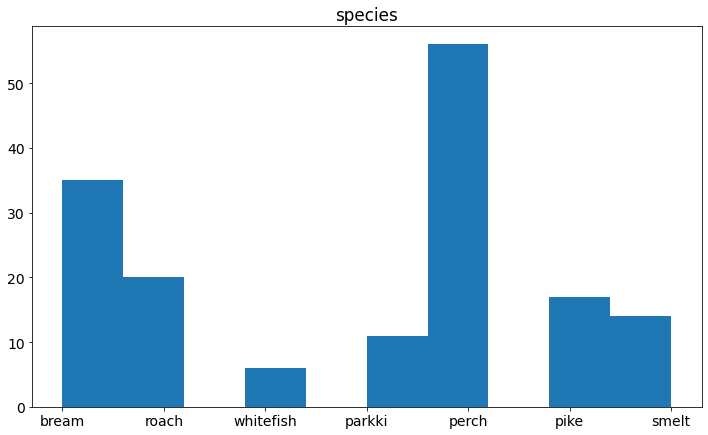

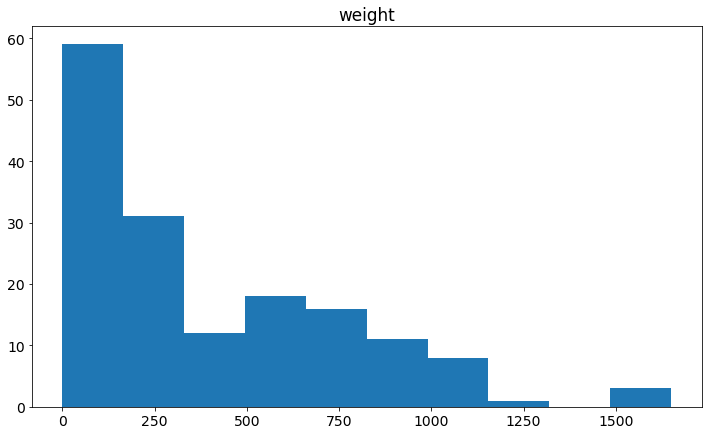

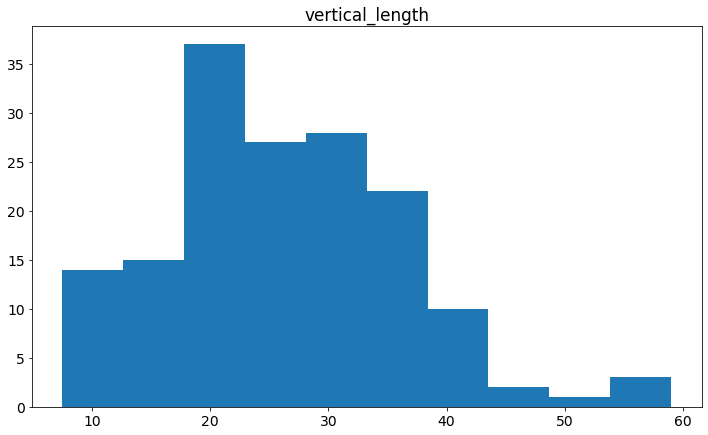

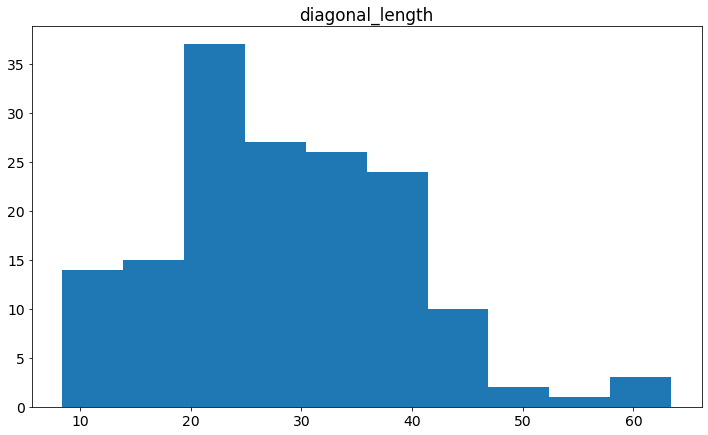

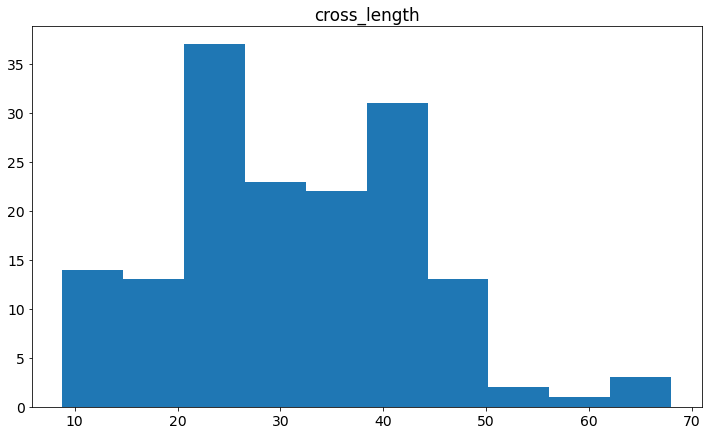

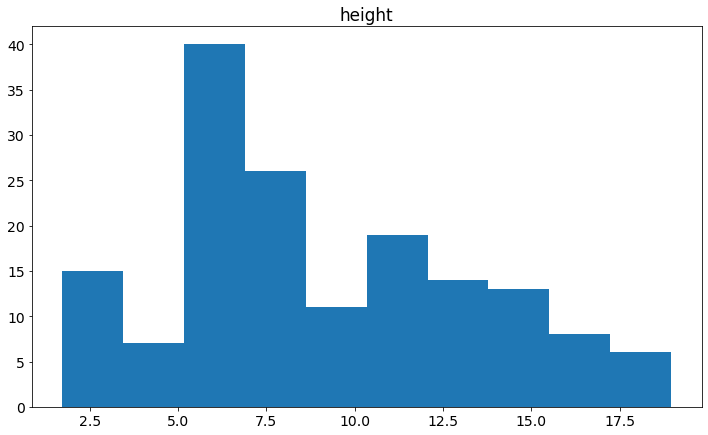

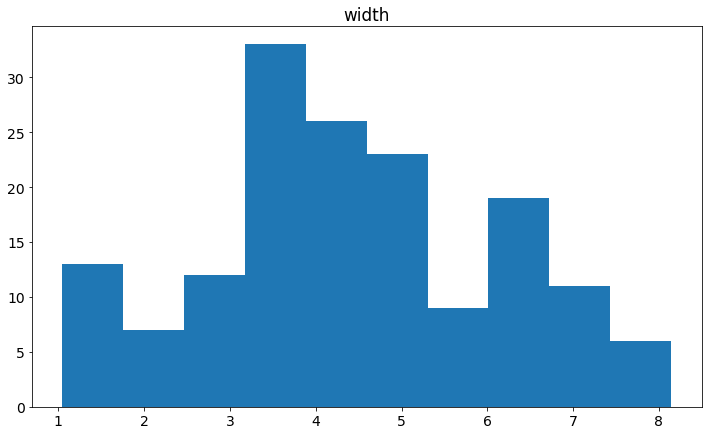

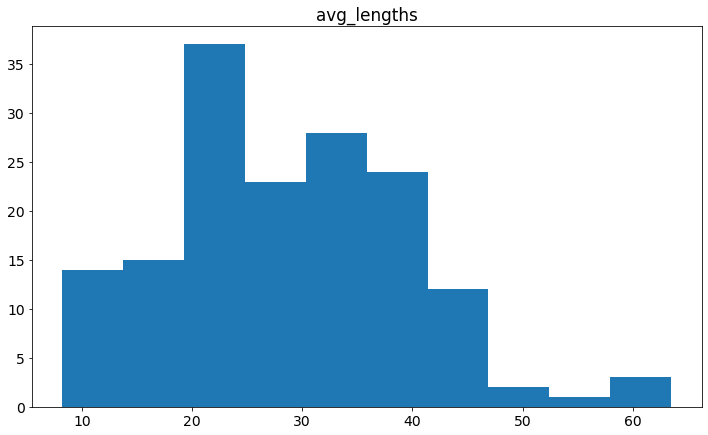

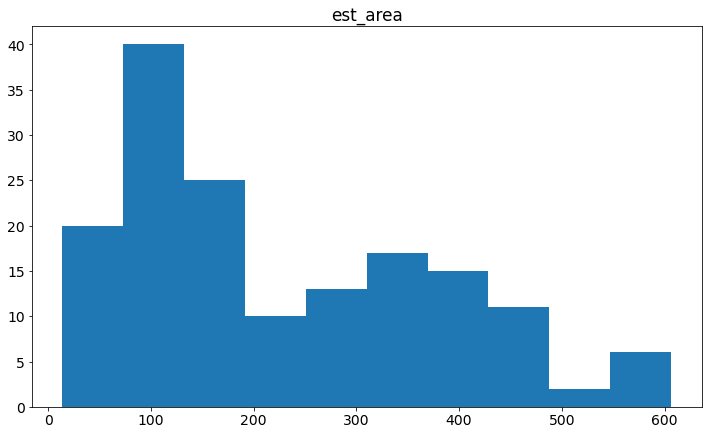

In [16]:
# Quick histograms of data
for col in df.columns:
        plt.hist(df[col])
        plt.title(col)
        plt.show()

## Going to convert cm to inches and weight into pounds (units we can relate to easier)

In [17]:
df['weight'] = round(df.weight * 0.00220462,2)
df.head()

,species,weight,vertical_length,diagonal_length,cross_length,height,width,avg_lengths,est_area
0,bream,0.53,23.2,25.4,30.0,11.5200,4.0200,26.20,237.05
1,bream,0.64,24.0,26.3,31.2,12.4800,4.3056,27.17,266.31
2,bream,0.75,23.9,26.5,31.1,12.3778,4.6961,27.17,264.13
3,bream,0.80,26.3,29.0,33.5,12.7300,4.4555,29.60,295.94
4,bream,0.95,26.5,29.0,34.0,12.4440,5.1340,29.83,291.54


In [18]:
# Converting lengths to inches
df['vertical_length'] = round(df.vertical_length*0.393701,2)
df['diagonal_length'] = round(df.diagonal_length*0.393701,2)
df['cross_length'] = round(df.cross_length*0.393701,2)
df['avg_lengths'] = round(df.avg_lengths*0.393701,2)
df.head()

,species,weight,vertical_length,diagonal_length,cross_length,height,width,avg_lengths,est_area
0,bream,0.53,9.13,10.00,11.81,11.5200,4.0200,10.31,237.05
1,bream,0.64,9.45,10.35,12.28,12.4800,4.3056,10.70,266.31
2,bream,0.75,9.41,10.43,12.24,12.3778,4.6961,10.70,264.13
3,bream,0.80,10.35,11.42,13.19,12.7300,4.4555,11.65,295.94
4,bream,0.95,10.43,11.42,13.39,12.4440,5.1340,11.74,291.54


In [19]:
# Converting height and width to inches
df['height'] = round(df.height*0.393701,2)
df['width'] = round(df.width*0.393701,2)

# Explore

In [20]:
df = pd.read_csv('Fish.csv')

In [21]:
df = prep_fish(df)

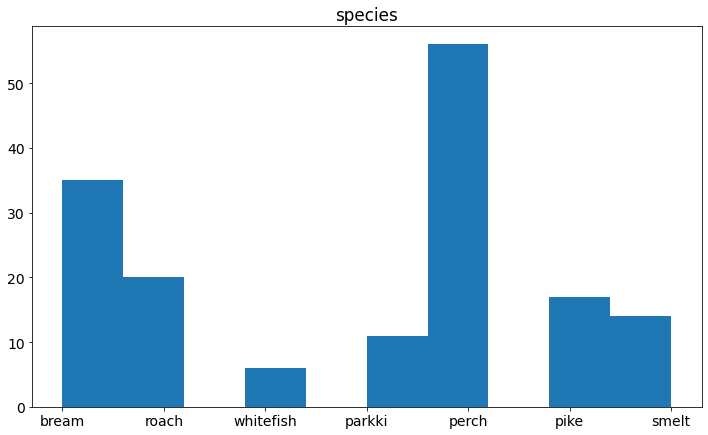

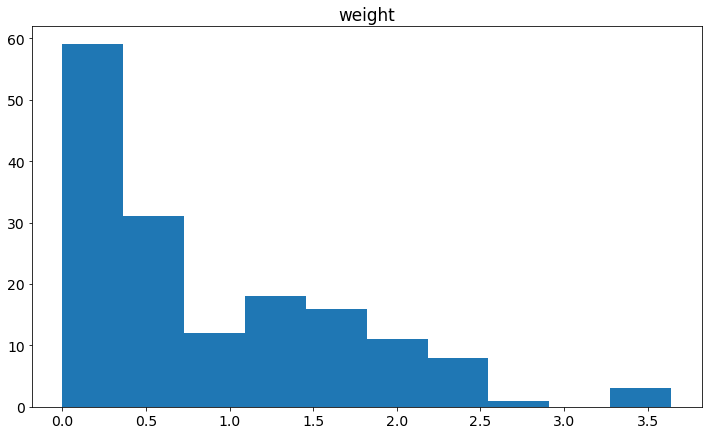

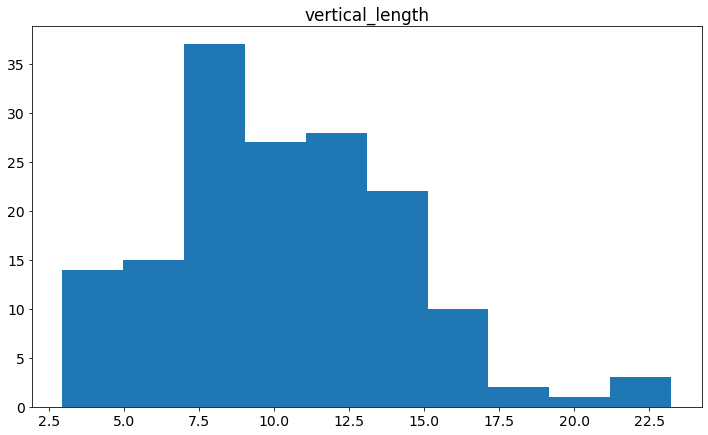

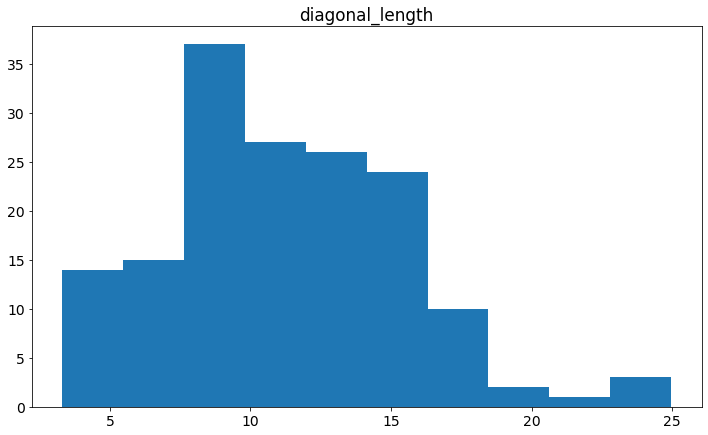

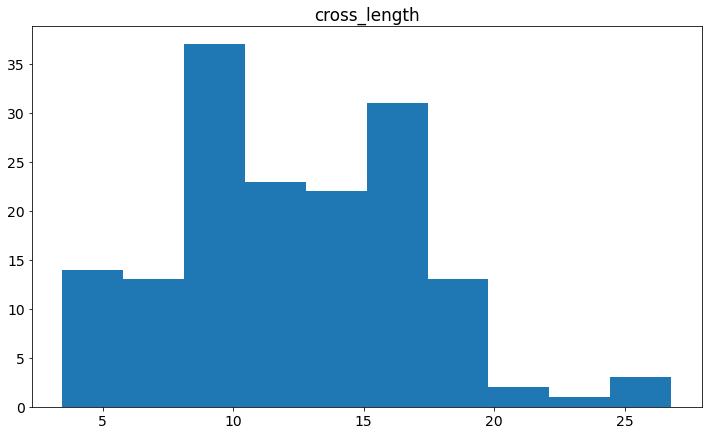

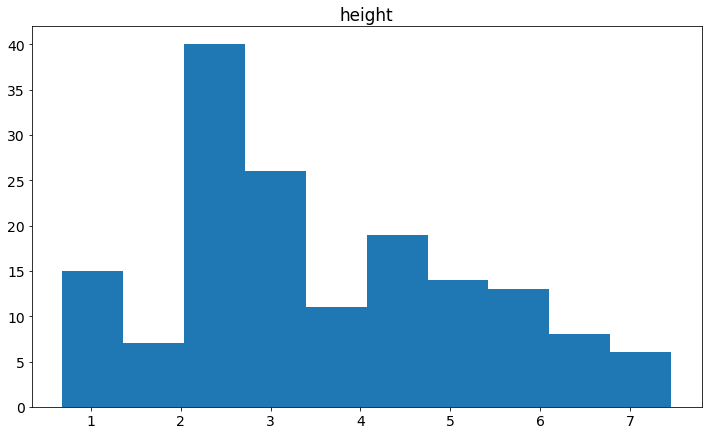

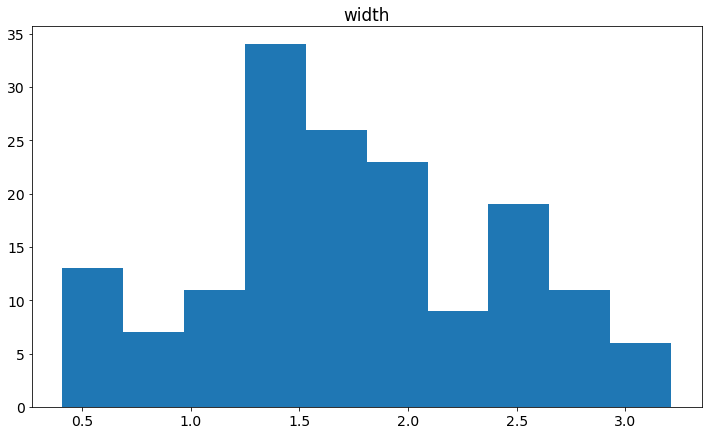

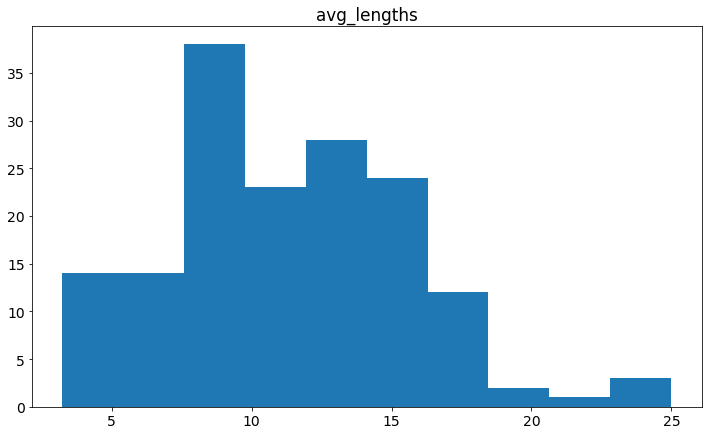

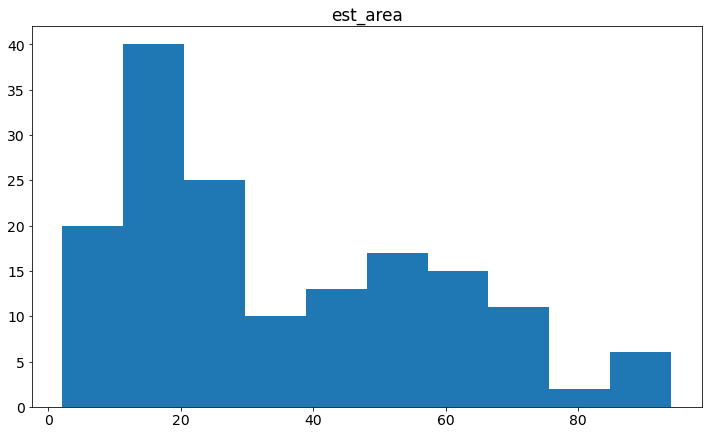

In [22]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

## Train, validate, test split

In [23]:
train, validate, test = fish_split(df)

The shape of the train data set is (83, 9)
The shape of the validate data set is (36, 9)
The shape of the test data set is (40, 9)


In [24]:
train.head()

,species,weight,vertical_length,diagonal_length,cross_length,height,width,avg_lengths,est_area
119,perch,1.87,14.53,15.75,16.65,4.70,2.80,15.64,57.73
30,bream,2.03,13.78,15.16,17.36,7.10,2.48,15.43,86.04
42,roach,0.26,7.64,8.27,9.33,2.41,1.30,8.41,15.92
89,perch,0.30,7.87,8.66,9.25,2.31,1.39,8.59,15.58
62,parkki,0.13,5.63,6.10,6.85,2.59,0.91,6.19,12.59


Text(0.5, 1.0, 'Correlation Heat Map')

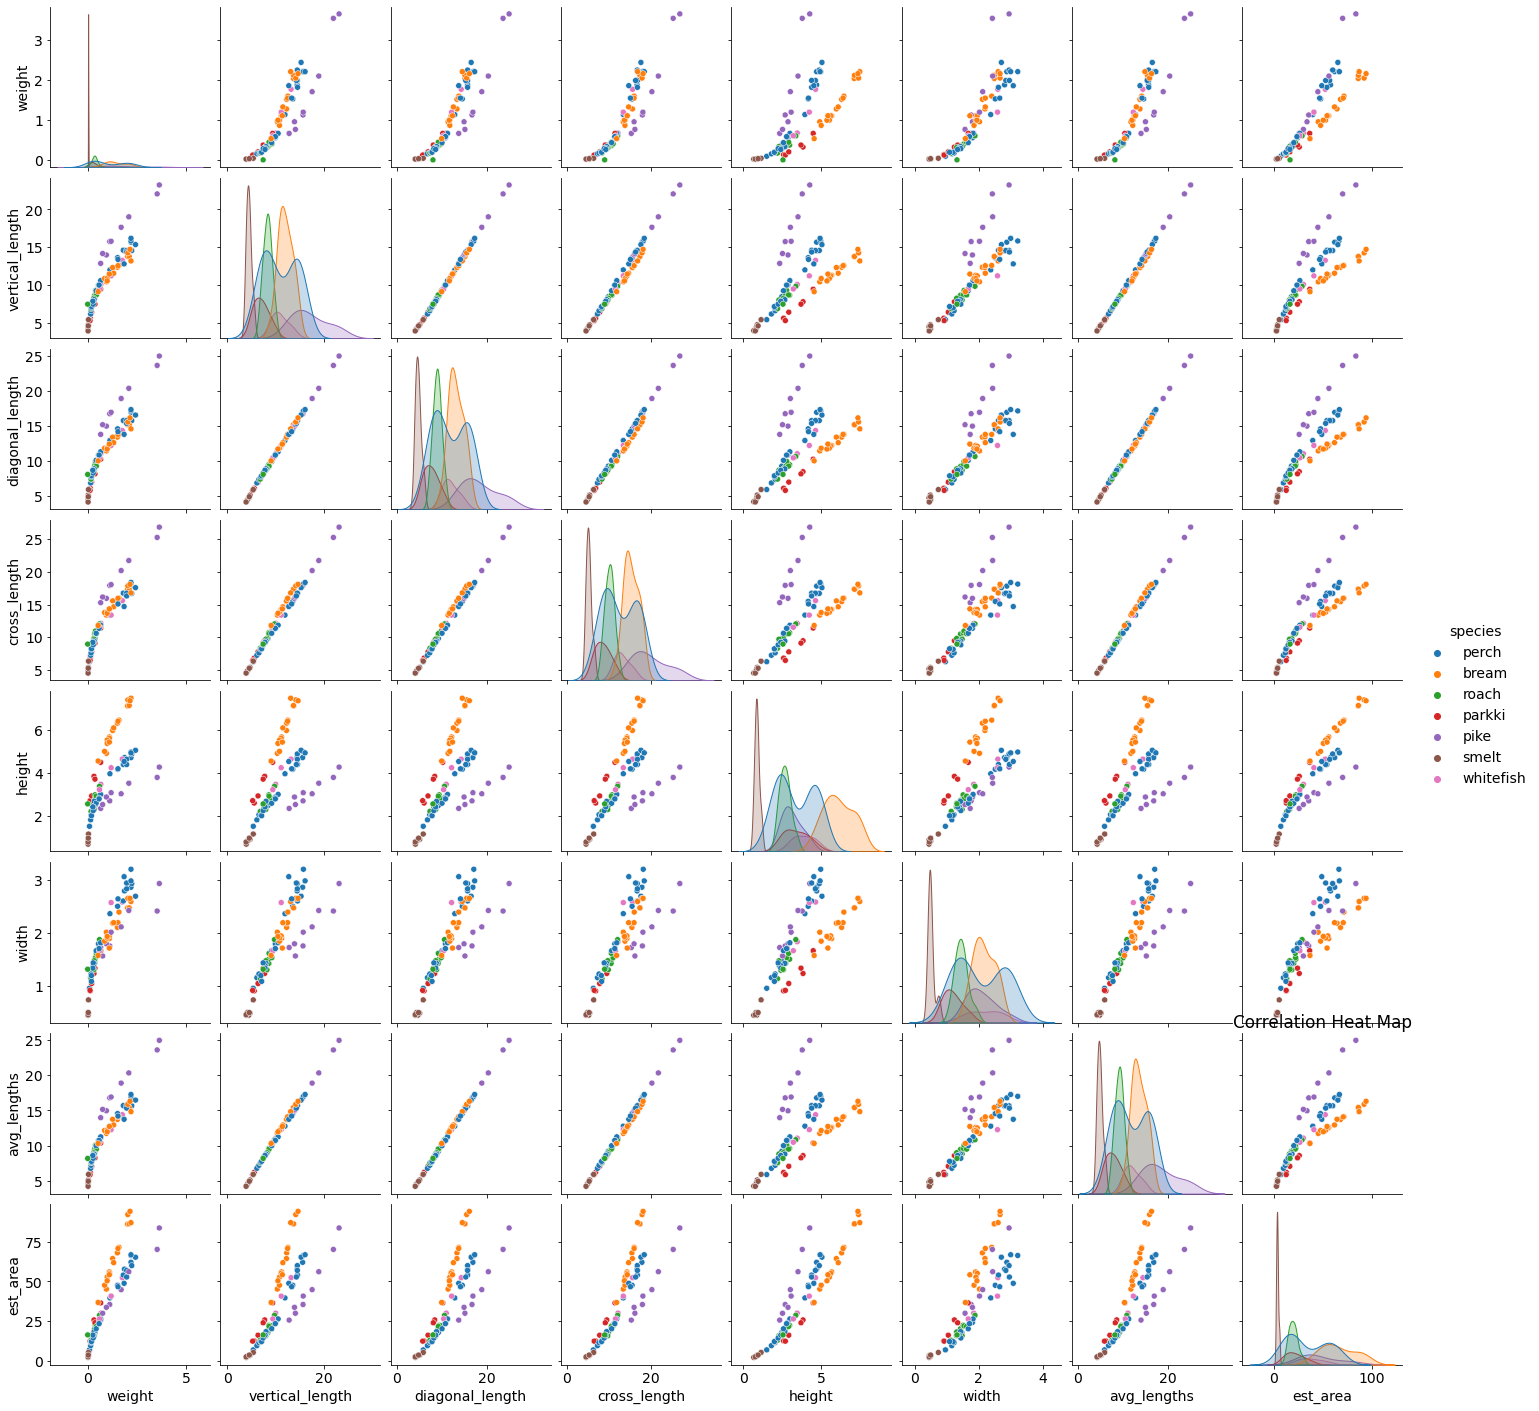

In [25]:
sns.pairplot(train, kind='scatter', hue='species')
plt.title('Correlation Heat Map')

### Distinct clusters of fish height, estimated area and avg length 

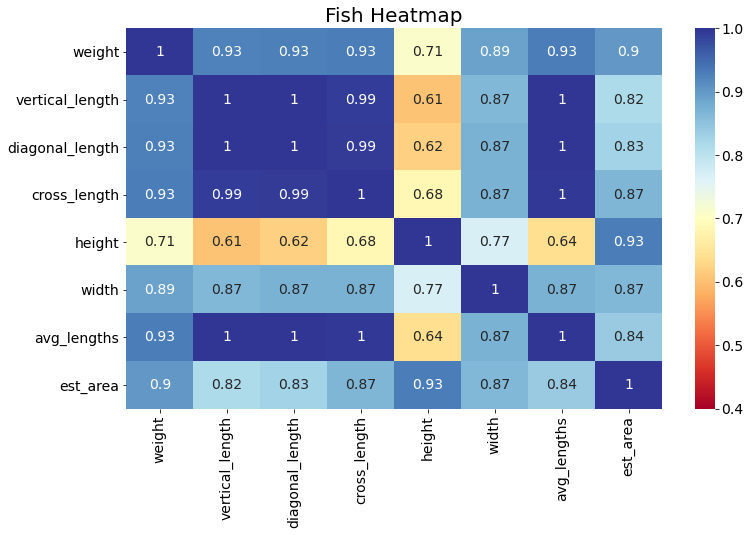

In [26]:
sns.heatmap(train.corr(),
            vmin = .4, 
            cmap='RdYlBu',
           annot=True).set_title("Fish Heatmap", fontsize=20);

### Good correlations between all lengths, width and estimated area. Going to run some statistical tests to confirm

In [27]:
# Looking at correlations of variables
train.corr()

,weight,vertical_length,diagonal_length,cross_length,height,width,avg_lengths,est_area
weight,1.000000,0.926116,0.929511,0.930973,0.710997,0.891888,0.930410,0.902687
vertical_length,0.926116,1.000000,0.999534,0.992190,0.606183,0.865193,0.998672,0.816730
diagonal_length,0.929511,0.999534,1.000000,0.994076,0.621755,0.871206,0.999354,0.827474
cross_length,0.930973,0.992190,0.994076,1.000000,0.683960,0.872511,0.997223,0.867044
height,0.710997,0.606183,0.621755,0.683960,1.000000,0.768868,0.640150,0.931358
width,0.891888,0.865193,0.871206,0.872511,0.768868,1.000000,0.871151,0.865328
avg_lengths,0.930410,0.998672,0.999354,0.997223,0.640150,0.871151,1.000000,0.839599
est_area,0.902687,0.816730,0.827474,0.867044,0.931358,0.865328,0.839599,1.000000


## Statistical Tests

## Height and Weight

H0: There is not linear correlation between the height and weights of fish.
alpha = .05

Text(0.5, 1.0, 'Height and Weight of Fish Species')

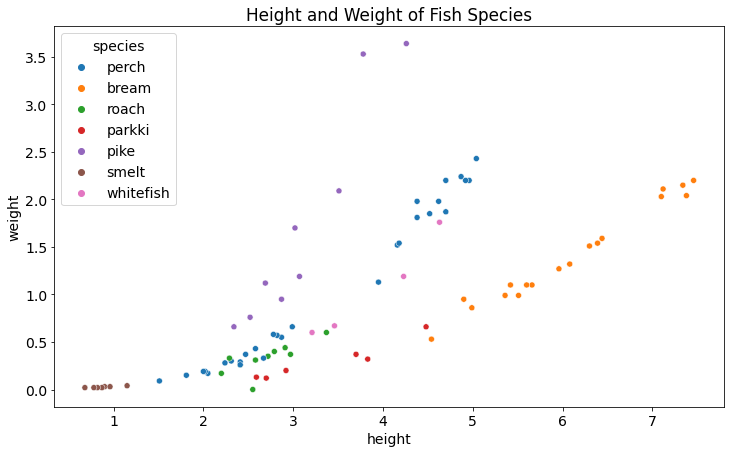

In [28]:
sns.scatterplot(x='height', y='weight', data=train, hue='species')
plt.title('Height and Weight of Fish Species')

In [29]:
alpha = .05
corr, p = stats.pearsonr(train.height, train.weight)
corr,p

(0.7109969637988472, 5.042568285812344e-14)

In [30]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")
print(f'The p-value is {p}.')

We reject the null hypothesis.
The p-value is 5.042568285812344e-14.


## Width and Weight

H0: There is not linear correlation between the width and weights of fish.
alpha = .05

Text(0.5, 1.0, 'Width and Weight of Fish Species')

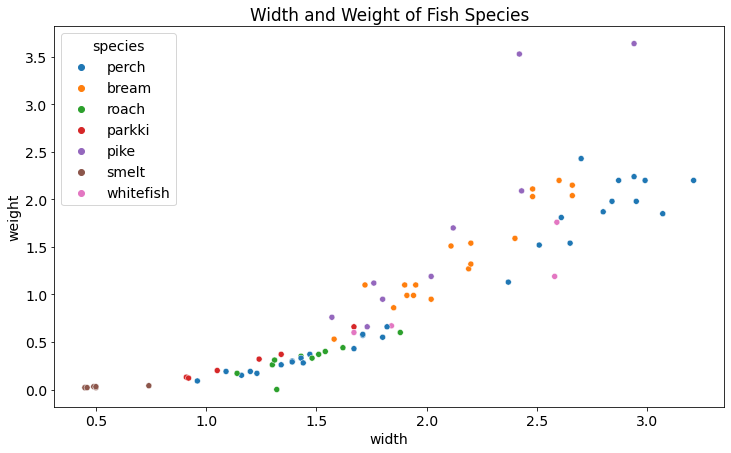

In [31]:
sns.scatterplot(x='width', y='weight', data=train, hue='species')
plt.title('Width and Weight of Fish Species')

In [32]:
alpha = .05
corr, p = stats.pearsonr(train.width, train.weight)
corr,p

(0.8918879502872175, 1.204693861479583e-29)

In [33]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")
print(f'The p-value is {p}.')

We reject the null hypothesis.
The p-value is 1.204693861479583e-29.


## Average Lengths and Weight

H0: There is not linear correlation between the average lengths and weights of fish.
alpha = .05

Text(0.5, 1.0, 'Avearage Lengths and Weight of Fish Species')

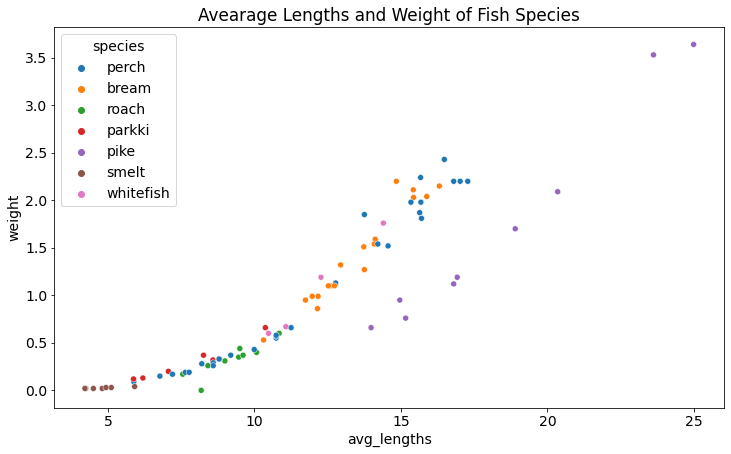

In [34]:
sns.scatterplot(x='avg_lengths', y='weight', data=train, hue='species')
plt.title('Avearage Lengths and Weight of Fish Species')

In [35]:
alpha = .05
corr, p = stats.pearsonr(train.avg_lengths, train.weight)
corr,p

(0.9304102195544139, 4.6641753977291775e-37)

In [36]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")
print(f'The p-value is {p}.')

We reject the null hypothesis.
The p-value is 4.6641753977291775e-37.


## All tests reject the null hypothesis, moving on and exploring further

Text(0.5, 1.0, 'Species Weights')

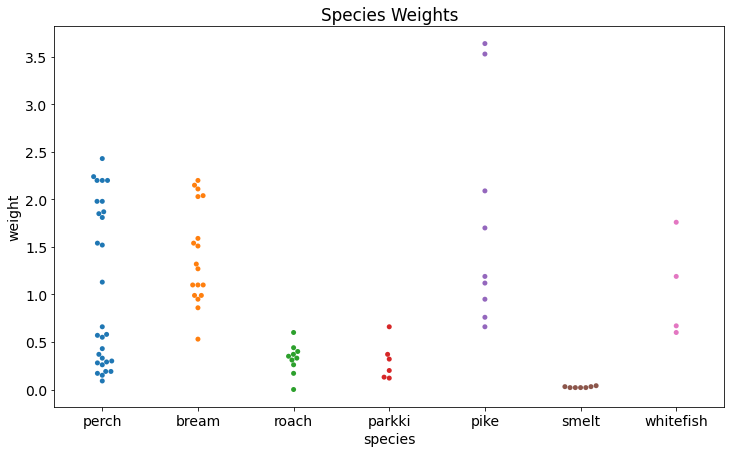

In [37]:
sns.swarmplot(data=train,x='species', y='weight')
plt.title("Species Weights")

### Interesting, there is a large variance in the pike size. Could be coincidence or outliers on the higher end. Have to investigate further. All other fish seem resonable with weight.

Text(0.5, 1.0, 'Average Species Length')

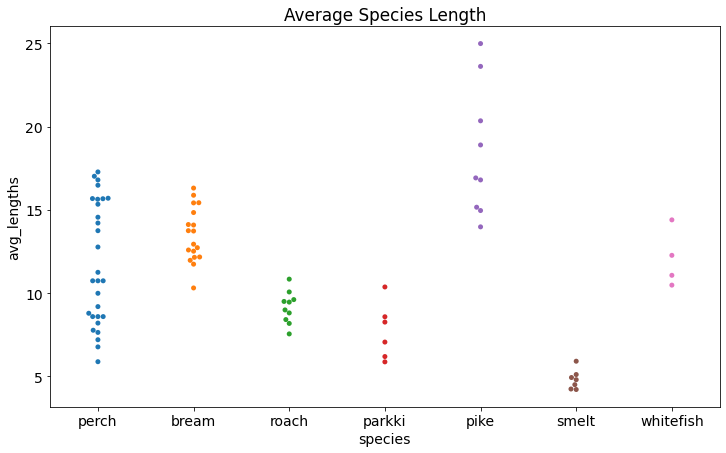

In [38]:
sns.swarmplot(data=train,x='species', y='avg_lengths')
plt.title("Average Species Length")

Text(0.5, 1.0, 'Species Weight Distribution')

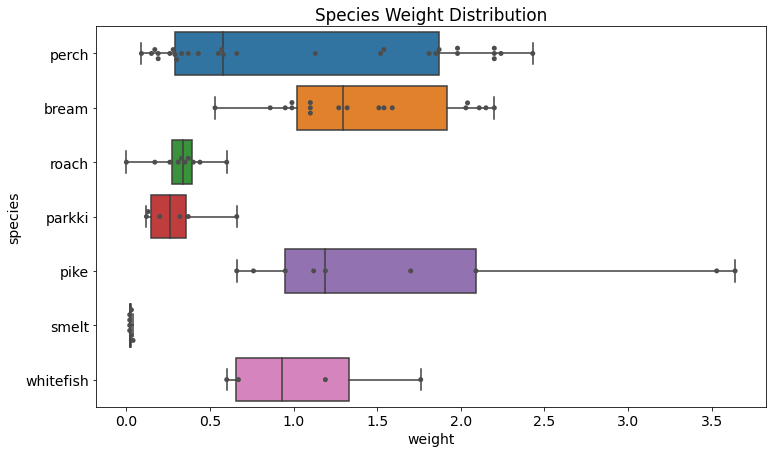

In [39]:
ax = sns.boxplot(x="weight", y="species", data=train, whis=np.inf)
ax = sns.swarmplot(x="weight", y="species", data=train, color=".3")
plt.title("Species Weight Distribution")

### Some research on pike showed that they range in size of 16-22 in on average with a record of 59 in. I found that on average, a 25 in pike will weigh ~3.8 lbs. The pike data points on the upper end were ~ 25 in and 3.5 lbs which are right in line what I found. 

As northern pike grow longer, they increase in weight, and the relationship between length and weight is not linear. The relationship between total length (L, in inches) and total weight (W, in pounds) for nearly all species of fish can be expressed by an equation of the form

{\displaystyle W=cL^{b}.}{\displaystyle W=cL^{b}.}
Invariably, b is close to 3.0 for all species, and c is a constant that varies among species. For northern pike, b = 3.096 and c = 0.000180 (c = 7.089 enables one to put length in meters and weight in kilograms).[9] The relationship described in this section suggests a 20-inch (510 mm) northern pike will weigh about 2 lb (0.91 kg), while a 26-inch (660 mm) northern pike will weigh about 4 lb (1.8 kg).

In [40]:
train.columns.to_list()

['species',
 'weight',
 'vertical_length',
 'diagonal_length',
 'cross_length',
 'height',
 'width',
 'avg_lengths',
 'est_area']

## Scaling data

In [41]:
columns_to_scale = ['weight','vertical_length','diagonal_length','cross_length','height','width','avg_lengths','est_area']
train_scaled, validate_scaled, test_scaled = add_scaled_columns(train, validate, test, MinMaxScaler(), columns_to_scale)

In [42]:
train_scaled.head()

,weight_scaled,vertical_length_scaled,diagonal_length_scaled,cross_length_scaled,height_scaled,width_scaled,avg_lengths_scaled,est_area_scaled
119,0.513736,0.548989,0.557849,0.544144,0.592920,0.851449,0.550048,0.604512
30,0.557692,0.510109,0.529525,0.576126,0.946903,0.735507,0.539942,0.913034
42,0.071429,0.191809,0.198752,0.214414,0.255162,0.307971,0.202117,0.148867
89,0.082418,0.203733,0.217475,0.210811,0.240413,0.340580,0.210780,0.145161
62,0.035714,0.087610,0.094575,0.102703,0.281711,0.166667,0.095284,0.112576


## Looking at my target variable `weight` to see distribution

<AxesSubplot:>

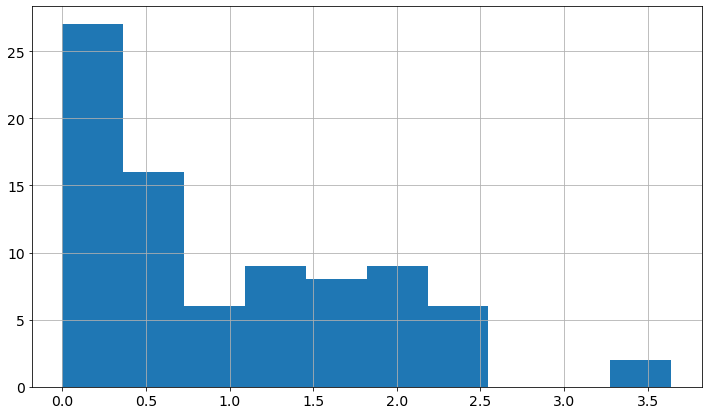

In [43]:
train.weight.hist()

### Distribution is not normal. Going to use the median to establish my baseline

## Establish baseline

In [44]:
# Establishing a baseline. Pre Req 1
baseline = train.weight.median()
print(baseline)
#print(np.median(y_train))

0.66


In [45]:
baseline_pred_mean = train['weight'].mean()
train['baseline_pred_mean'] = baseline_pred_mean

In [46]:
baseline_pred_mean

0.9736144578313255

## Ordinary Least Squares Regression with weight and average lengths

In [47]:
# Setting up variables for ols model
y= train.weight
x= train.avg_lengths
data=train

In [48]:
y, evaluate = ols_model(y, x, data, baseline)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 66.35369999999999
Model SSE 7.817102155779006


In [49]:
evaluate.head()

,x,y,baseline,yhat,baseline_residuals,model_residual
119,15.64,1.87,0.66,1.691227,-1.21,-0.178773
30,15.43,2.03,0.66,1.653152,-1.37,-0.376848
42,8.41,0.26,0.66,0.380363,0.40,0.120363
89,8.59,0.30,0.66,0.412998,0.36,0.112998
62,6.19,0.13,0.66,-0.022143,0.53,-0.152143


In [50]:
# y array of actual y values (weights) evaluate.yhat is the predictions
median_absolute_error(y, evaluate.yhat)

0.19484981347665942

<AxesSubplot:title={'center':'Actual vs Residual'}, xlabel='actual value ($y$)', ylabel='residual ($y - \\hat{y}$)'>

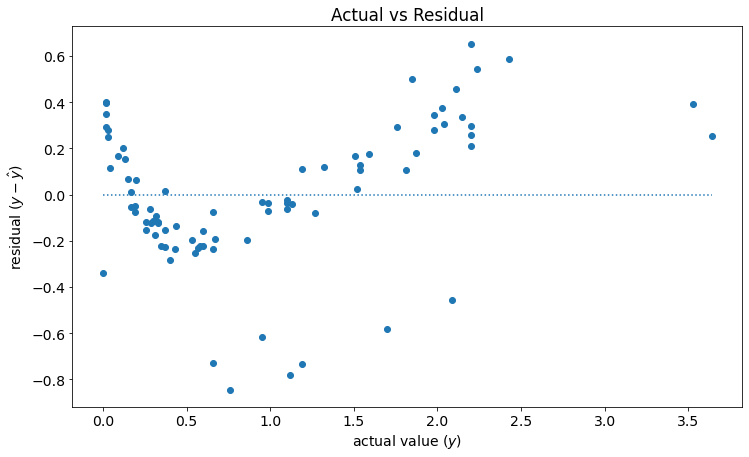

In [51]:
plot_residuals(y, evaluate.yhat)

## Ordinary Least Squares Regression with weights and width

In [52]:
# Setting up variables for ols model
y= train.weight
x= train.width
data=train

In [53]:
y, evaluate = ols_model(y, x, data, baseline)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 66.35369999999999
Model SSE 11.902007662007536


In [54]:
# y array of actual y values (weights) evaluate.yhat is the predictions
median_absolute_error(y, evaluate.yhat)

0.21586872043537986

<AxesSubplot:title={'center':'Actual vs Residual'}, xlabel='actual value ($y$)', ylabel='residual ($y - \\hat{y}$)'>

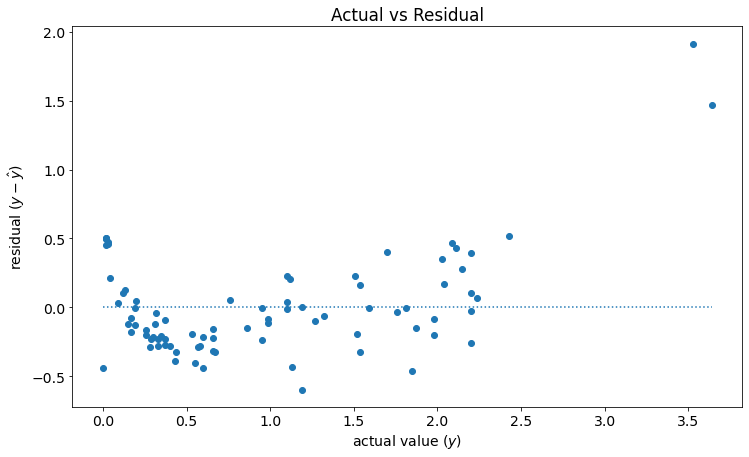

In [55]:
plot_residuals(y, evaluate.yhat)

## Ordinary Least Squares Regression with weights and height

In [56]:
y= train.weight
x= train.height
y, evaluate = ols_model(y, x, data, baseline)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 66.35369999999999
Model SSE 28.774140333425354


In [57]:
median_absolute_error(y, evaluate.yhat)

0.293086472221081

<AxesSubplot:title={'center':'Actual vs Residual'}, xlabel='actual value ($y$)', ylabel='residual ($y - \\hat{y}$)'>

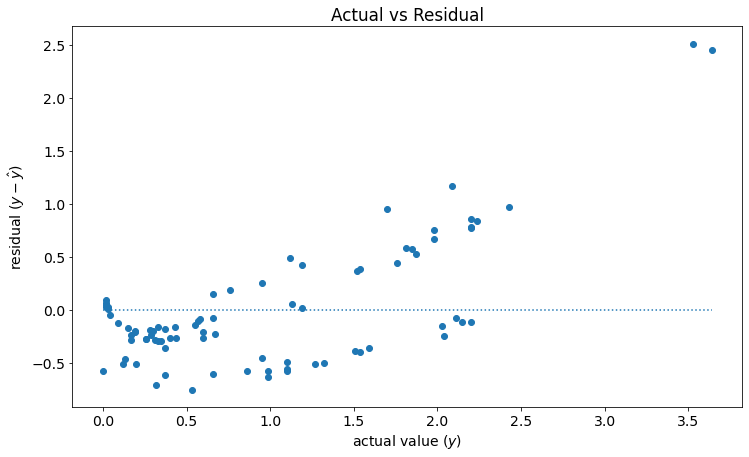

In [58]:
plot_residuals(y, evaluate.yhat)

## Ordinary Least Squares Regression with weights and estimated area

In [59]:
y= train.weight
x= train.est_area
y, evaluate = ols_model(y, x, data, baseline)

Our model out performed our baseline
It makes sense to evaluate this model more thoroughly
Baseline SSE 66.35369999999999
Model SSE 10.77434722714355


In [60]:
median_absolute_error(y, evaluate.yhat)

0.12670934840844658

<AxesSubplot:title={'center':'Actual vs Residual'}, xlabel='actual value ($y$)', ylabel='residual ($y - \\hat{y}$)'>

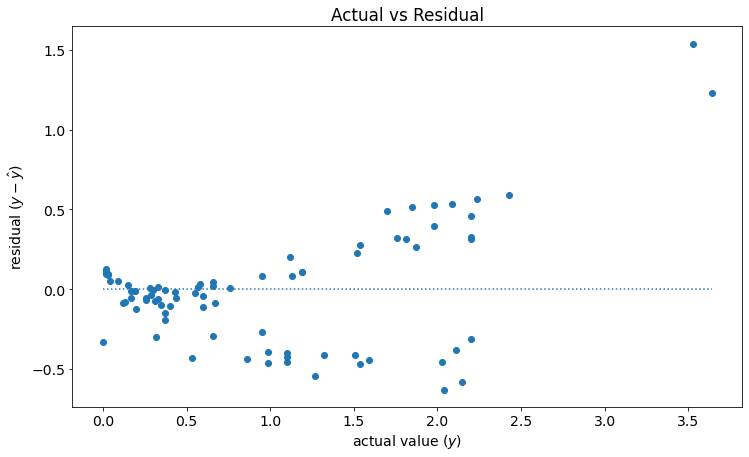

In [61]:
plot_residuals(y, evaluate.yhat)

## Regression Models with all features

In [62]:
y_train = train[['weight']]
columns_to_scale = ['vertical_length','diagonal_length','cross_length','height','width','avg_lengths','est_area']
X_train_scaled, X_validate_scaled, X_test_scaled = add_scaled_columns(train, validate, test, MinMaxScaler(), columns_to_scale)

## Linear Regression

In [63]:
lm_pred = linear_regression(X_train_scaled, y_train)

The models median absolute error is 0.063


## Laso Lars

In [64]:
laso_lars(X_train_scaled, y_train)

The models median absolute error is 0.821


## Polynomial Regression (k=2 degrees `quadratic`)

In [65]:
polynomial_features(X_train_scaled, y_train)

The models median absolute error is 0.086


### Linear and Polynomial models performed well. LasoLars not so good. Going to run another set of models with fewer features and re-evaluate

## Regression Models with height, width, avg_lengths and est_area

In [66]:
columns_to_scale = ['height','width','avg_lengths','est_area']
y_train= train[['weight']]
y_validate= validate[['weight']]
y_test= test[['weight']]

X_train_scaled, X_validate_scaled, X_test_scaled  = add_scaled_columns(train, validate, test, MinMaxScaler(), columns_to_scale)

## Linear Regression

In [67]:
lm_pred = linear_regression(X_train_scaled, y_train)

The models median absolute error is 0.053


## Laso Lars

In [68]:
laso_lars(X_train_scaled, y_train)

The models median absolute error is 0.821


## Polynomial Regression (k=2 degrees `quadratic`)

In [69]:
polynomial_features(X_train_scaled, y_train)

The models median absolute error is 0.04


## My models that had height, width avg_lengths, and est_area performed better than the models with all the features. Moving to the validate phase

# Validating

## Linear Regression

In [70]:
lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train)

LinearRegression(normalize=True)

In [71]:
# Prediction of our validation set
lm_pred_v = lm.predict(X_validate_scaled)
lm_mse = median_absolute_error(y_validate, lm_pred_v)
print(f'The models median absolute error is {round(lm_mse,3)}')

The models median absolute error is 0.104


## Laso Lars

In [72]:
lars = LassoLars(alpha=1)
lars.fit(X_train_scaled, y_train)

LassoLars(alpha=1)

In [73]:
# Prediction of our validation set
lars_pred_v = lars.predict(X_validate_scaled)
# compute root mean squared error
lars_mse_v = median_absolute_error(y_validate, lars_pred_v)**(1/2)
print(f'The models median absolute error is {round(lars_mse_v,3)}')

The models median absolute error is 0.79


## Polynomial

In [74]:
# make the polynomial thing
pf = PolynomialFeatures(degree=2)

# fit and transform the thing
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
# Fit the model
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)

LinearRegression()

In [75]:
# New features squared
X_validate_squared = pf.transform(X_validate_scaled)
# Prediction of our Test set
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
lm_squared_mae_v = median_absolute_error(y_validate, lm_squared_pred_v)
print(f'The models median absolute error is {round(lm_squared_mae_v,3)}')

The models median absolute error is 0.042


## The polynomial model performed the best on train and validate. Going to Test

# Test

## Polynomial Regression

In [76]:
# New features squared
X_test_squared = pf.transform(X_test_scaled)
# Prediction of our Test set
lm_squared_pred_t = lm_squared.predict(X_test_squared)
lm_squared_mae_t = median_absolute_error(y_test, lm_squared_pred_t)
print(f'The models median absolute error is {round(lm_squared_mae_t,3)}')

The models median absolute error is 0.054


In [77]:
y_test['lm_prediction'] = lm_squared.predict(X_test_squared)
y_test['baseline_pred'] = np.median(y_train)
y_test['est_error'] = (y_test.weight - y_test.lm_prediction)/y_test.weight

In [102]:
y_test.head(5)

,weight,lm_prediction,baseline_pred,est_error
35,0.09,0.143022,0.66,-0.589137
25,1.60,1.722573,0.66,-0.076608
145,0.01,-0.007292,0.66,1.729163
108,0.71,0.654166,0.66,0.078639
112,1.51,1.579760,0.66,-0.046199


In [78]:
# Estimated average error of model in the test data set. 
y_test.est_error.mean()

-0.030247959945617874

In [79]:
y_test.lm_prediction.median()

0.5180623719537192

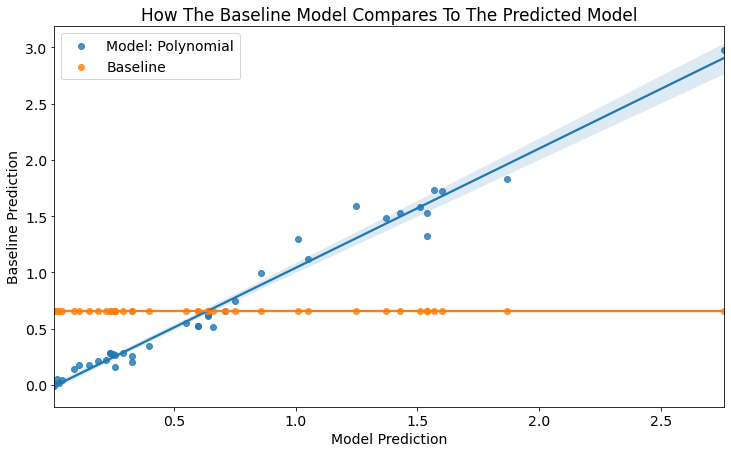

In [80]:
sns.regplot(x="weight", y="lm_prediction", data=y_test, label="Model: Polynomial")
sns.regplot(x="weight", y="baseline_pred", data=y_test, label="Baseline")
plt.title("How The Baseline Model Compares To The Predicted Model")
plt.xlabel('Model Prediction')
plt.ylabel('Baseline Prediction')
plt.legend()

In [81]:
# Model performed 92% better above baseline
round((baseline - lm_squared_mae_t)/ baseline ,2) * 100

92.0

In [90]:
from sklearn.metrics import explained_variance_score

```Explained variance``` (also called explained variation) is used to measure the discrepancy between a model and actual data. In other words, it’s the part of the model’s total variance that is explained by factors that are actually present and isn’t due to error variance.

In [93]:
# 97% of the variance in weight is explained by my 4 features in the model
evs = explained_variance_score(y_test.weight, y_test.lm_prediction)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.972


In [95]:
# Estimated average error of model in the test data set. 
y_test.est_error.mean()

-0.030247959945617874

In [96]:
baseline

0.66

In [97]:
lm_squared_mae_t

0.05442811392463158

In [98]:
# Model performed 60% above baseline
baseline - lm_squared_mae_t

0.6055718860753685

### Model performed great on test. My model has an median absolute error of ~.05 lbs. The model has an explained variance score of  0.972.
    - Model was consistent on all phases of train, validate, test ~.05 median absolute error.
    - Going foward, I would like to apply this model to other species of fish to see if it could as accurately predict the weight given the same metrics.